<a href="https://colab.research.google.com/github/agha-pedram/Urban_Suit_Pollution_by_Mesa/blob/main/Urban_Suite_Pollution_by_Mesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mesa

In [1]:
import mesa
import random

In [2]:
class HumanAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, birth_rate,plant_rate, model):
        super().__init__(unique_id, model)
        self.health = 5
        self.birth_rate = birth_rate
        self.plant_rate=plant_rate

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def decrease_health(self):
        if self.health >= 0.1:
            self.health -= 0.1

            cellmates=self.model.grid.get_cell_list_contents([self.pos])
            for cellmate in cellmates:
              if isinstance(cellmate, PollutionAgent):
                self.health -= cellmate.pollution / 10

        else: # kill this agent
          self.model.grid.remove_agent(self)
          self.model.schedule.remove(self)
          self.model.num_humans -=1

    def step(self):
      
      

      self.move()

      
    
      if (random.random()<self.birth_rate) & (self.health > 4):      
        a = HumanAgent(self.model.num_agents,self.birth_rate,self.plant_rate,self.model)
        self.model.num_agents +=1
        self.model.num_humans +=1
        self.model.schedule.add(a)
        self.model.grid.place_agent(a, self.pos)
      
      if random.random()<self.plant_rate:      
        a = TreeAgent(self.model)
        self.model.schedule.add(a)
        self.model.grid.place_agent(a, self.pos)

      self.decrease_health()

        

In [3]:
class TreeAgent(mesa.Agent):

    def __init__(self,  model):
        super().__init__(self, model)
        self.health = 5

    def decrease_tree_health(self):
        if self.health >= 0.1:
          self.health -= 0.1
        else:
          self.model.grid.remove_agent(self)
          self.model.schedule.remove(self)

    def step(self):
        self.decrease_tree_health()

In [4]:
class PollutionAgent(mesa.Agent):

    def __init__(self, pollution,fix,model):
        super().__init__(self,model)
        self.pollution = pollution
        self.fix=fix
        

    def spread_pollution(self):
      diff=0.8
      neighbors = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=True)
    
      all_p = 0
      x=0
      TreeNeighbor=False
      for n in neighbors:
        # print(n)
        if isinstance(n, PollutionAgent):
          all_p += n.pollution
          x+=1
        if isinstance(n, TreeAgent):
          TreeNeighbor=True
        
      
      ave_p = all_p / x
      add_polution=(diff * (ave_p - self.pollution))
      self.pollution += add_polution

      # cellmates=self.model.grid.get_cell_list_contents([self.pos])
      # for cellmate in cellmates:
      #   if isinstance(cellmate, TreeAgent):
      #     self.pollution=0

      if TreeNeighbor:
        self.pollution=0
      

    def step(self):
      if not self.fix:
        self.spread_pollution()

In [5]:
def human_population(model):
    populaion = [agent.unique_id for agent in model.schedule.agents if isinstance(agent, HumanAgent)]
    # print(type(agent_healths[0]))
    return len(populaion)

def tree_population(model):
    populaion = [agent.unique_id for agent in model.schedule.agents if isinstance(agent, TreeAgent)]
    return len(populaion)


def total_pollution(model):
    pollution = [agent.pollution for agent in model.schedule.agents if isinstance(agent, PollutionAgent)]
    return sum(pollution)

class UrbanModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N ,birth_rate,plant_rate,power_plants,pollution_rate):
        width=80
        height=80
        self.num_agents = N
        self.num_humans =N
        self.birth_rate=birth_rate
        self.power_plants=power_plants
        self.pollution_rate=pollution_rate
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create pollution agent in all cells with pollution=0
        for (contents, x, y) in self.grid.coord_iter():
          cell = PollutionAgent(0,False,self)
          self.grid.place_agent(cell, (x, y))
          self.schedule.add(cell)
        
        # Create number of power plants
        for i in range(self.power_plants):
          a = PollutionAgent(pollution_rate,True,self)
          self.schedule.add(a)
          # Add the agent to a random grid cell
          x = self.random.randrange(self.grid.width)
          y = self.random.randrange(self.grid.height)
          self.grid.place_agent(a, (x, y))

        # Create human agents
        for i in range(self.num_agents):
            a = HumanAgent(i,birth_rate,plant_rate,self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Human_Population": human_population,
                             "Tree_Numbers": tree_population,
                             "total pollution": total_pollution})


    def step(self):
        # print("main step",self)
        self.datacollector.collect(self)
        self.schedule.step()

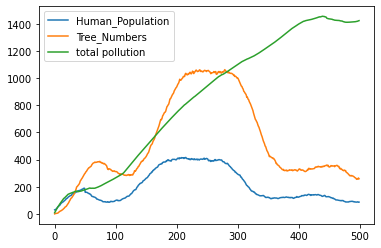

In [7]:
model = UrbanModel(N=30,birth_rate=0.09,plant_rate=0.05,power_plants=3,pollution_rate=3)
for i in range(500):
    model.step()
    if model.num_humans ==0:
      break

data = model.datacollector.get_model_vars_dataframe()
data.plot()